# Get started
1. [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/active-learning/2_Klassifikation_mit_ScikitActiveML.ipynb)
2. Klicke auf Laufzeit > Laufzeittyp ändern > T4 GPU > Ändern
3. Führe die folgende Zelle aus, um benötigte Requirements zu installieren. Klicke anschließend auf "Restart Session".

In [ ]:
!pip install scikit-activeml

4. Führe die nächste Zelle aus, um die benötigten Daten in die Session zu laden.

In [ ]:
!wget -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/Cancer/data_dev.csv
!wget -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/Cancer/data_test.csv

-------------AB HIER BEGINNT DAS EIGENTLICHE NOTEBOOK--------------------

# Klassifikation mit Scikit ActiveML 

In diesem Beispiel befassen wir uns mit der Klassifizierung von Brustkrebs. Der Labelingprozess für Brustkrebsdiagnosen erfordert Expertenwissen und ist zeitaufwendig. Daher möchten wir Active Learning nutzen, um die Kosten und den Zeitaufwand für das Labeling zu reduzieren. Active Learning ermöglicht es uns, intelligent die informativsten Proben für das Labeling auszuwählen, wodurch der Bedarf an gelabelten Daten verringert wird.


## Inhaltsverzeichnis
1. [Imports](#Imports)
2. [Laden der Daten](#Laden-der-Daten)
3. [Initialisierung](#Initialisierung-des-Modells)
4. [Umsetzung des Active Learning Cycles](#Umsetzung-des-Active-Learning-Cycles)
5. [Evaluation](#Evaluation)


## 1. Imports <a id='Imports'></a>

Die Python-Bibliotheken `pandas` und `numpy` finden Anwendung beim Laden und Verarbeiten von Daten. Zur Erstellung von Visualisierungen bedienen wir uns der Bibliothek `matplotlib`. Für die Umsetzung von Klassifikationsaufgaben verwenden wir eine Support Vector Machine (`SVC` aus der `sklearn`-Bibliothek).

Spezifische Funktionen, die im Kontext des Active Learning gebraucht werden, werden aus dem Modul `skactiveml` bezogen. Konkret importieren wir die Klasse `SklearnClassifier` aus dem Modul `skactiveml.classifier`. Diese dient als Erweiterung eines Sklearn-Klassifikators und ermöglicht eine nahtlose Einbindung in den Active Learning-Prozess.

Die Implementierung des Auswahlstrategie wird durch die Klasse `UncertaintySampling` aus `skactiveml.pool` zur Verfügung gestellt. Zusätzlich nutzen wir die Funktionen `unlabeled_indices` und `MISSING_LABEL` aus dem Modul `skactiveml.utils`, um mit fehlenden Labels umzugehen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC

from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

from warnings import filterwarnings
filterwarnings("ignore")

## 2. Laden der Daten <a id=Laden-der-Daten></a>
Die Daten stammen aus dem [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) und sind als "Breast Cancer Wisconsin (Diagnostic) Dataset" bekannt. Sie enthalten Informationen zu verschiedenen Merkmalen von Brustgewebeproben und die Zielvariable gibt an, ob ein Tumor gutartig (benign) oder bösartig (malignant) ist.
Die Daten wurden bereits vorab normalisiert und in Entwicklungs- und Testdaten unterteilt.

Die tatsächlichen Labels werden in der Variable `y_true` gespeichert. Bitte beachten Sie, dass in einem realen Szenario diese Labels nicht verfügbar wären. Zusätzlich wird die Variable `y` als leeres Array mit derselben Größe initialisiert und wird nach und nach mit den im Active Learning Cycle bestimmten Labels befüllt.

In [2]:
data_dev = pd.read_csv("./data/cancer/data_dev.csv")
data_test = pd.read_csv("./data/cancer/data_test.csv")

X = data_dev.drop(columns=['label'])
y_true = data_dev['label']
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

X_test = data_test.drop(columns=['label'])
y_test = data_test['label'] 

## 3. Initialisierung <a id="Initialisierung-des-Modells"></a>

Um einen Klassifikator zu initialisieren, erstellen wir eine Instanz der Klasse `SklearnClassifier`. Diese benötigt einen Sklearn-Estimator, die Namen der möglichen verschiedenen Klassen und optional noch einen random_state, damit dsa Experiment reproduzierbar ist.

Für unser Beispiel verwenden wir den SVC (Support Vector Classifier) von sklearn als Estimator und die Klassen aus den tatsächlichen Labels `y_true` als Namen der möglichen verschiedenen Klassen.

In [3]:
clf = SklearnClassifier(
    estimator=SVC(probability=True), 
    classes=np.unique(y_true),
    random_state=42
)

Als nächstes initialsieren wir unser Entscheidungskriterium (Query Strategie), nach welchem die Datenpunkte ausgewählt werden. Dazu initialiseren wir eine Instanz der Klasse `UncertaintySampling` und übergeben als String die gewünschte Methode. Zur Auswahl stehen `entropy`, `least_confident`, `margin_sampling` und `expected_average_precision`.

In [4]:
qs = UncertaintySampling(method='entropy')

## 4. Umsetzung des Active Learning Cycles <a id="Umsetzung-des-Active-Learning-Cycles"></a>



Als initiale Trainingsdaten verwenden wir die ersten 10 Indizes (Kaltstart). Natürlich kennen wir auch die Klassen aller restlichen Datenpunkte, aber wir tun nun so, als würden wir nur die Label der ersten 10 Datenpunkte kennen.

In [5]:
y[:10] = y_true[:10]
y[:30] # Zeigt die ersten 30 Labels an

array([ 0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1., nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

Wir implementieren den Active Learning Cycle mithilfe einer FOR-Schleife, die `n_cycles` Iterationen durchläuft. In jeder Iteration erfolgt zuerst das Training eines Modells mit den aktuellen Trainingsdaten, gefolgt von einer Bewertung seiner Leistung anhand der Testdaten. Die Ergebnisse dieser Bewertungen werden in der Liste `performance` gespeichert. Danach nutzen wir unser Entscheidungskriterium, um den Datenpunkt zu identifizieren, der derzeit am unsichersten einer bestimmten Klasse zugeordnet ist. Wir bestimmen das Label für diesen Datenpunkt und fügen ihn den Trainingsdaten hinzu. 

In [6]:
n_cycles = 140
performance = []

# Active Learning Cycle
np.random.seed(42)
for cycle in range(n_cycles):
    print(f"Query no. {cycle+1} of {n_cycles}", end="\r")
    clf.fit(X,y)
    performance.append(clf.score(X_test, y_test))
    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)
    y[query_idx] = y_true[query_idx]

## 5. Evaluation <a id="Evaluation"></a>
Um die von uns gewählte Strategie zu bewerten, vergleichen wir diese mit einer zufälligen Auswahl der Datenpunkte (Random-Strategie).


In [7]:
#Initialisierung des Klassifikators
clf_random = SklearnClassifier(
    estimator=SVC(probability=True),
    classes=np.unique(y_true)
)

#Initialiserung der Daten
y_random = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
y_random[:10] = y_true[:10]

#Initialisierung der Performance Liste
performance_random = []

# Random Learning Cycle
np.random.seed(42)
for c in range(n_cycles):
    print(f"Query no. {c+1} of {n_cycles}", end="\r")
    clf_random.fit(X,y_random)
    performance_random.append(clf_random.score(X_test, y_test))
    query_idx = np.random.choice(unlabeled_indices(y_random), size=1, replace=False) # Zufällige Auswahl eines noch nicht gelabelten Datensatzes
    y_random[query_idx] = y_true[query_idx]

Zum Vergleich visualisieren wir die Performance der beiden Strategien.

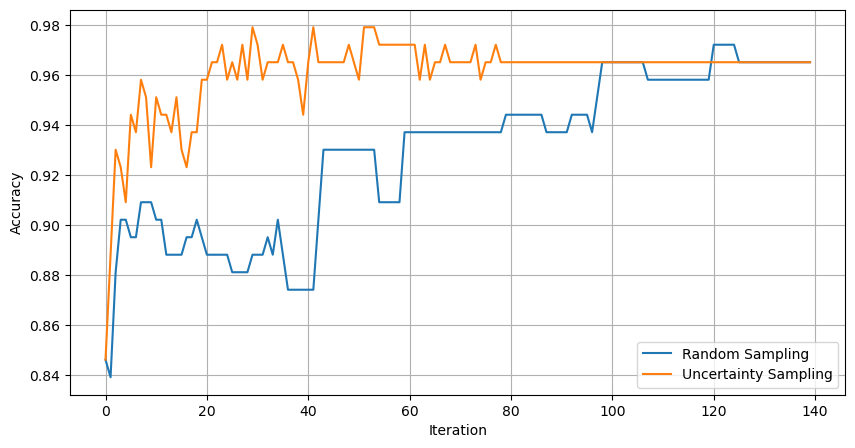

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(performance_random, label="Random Sampling")
plt.plot(performance, label="Uncertainty Sampling")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc=4)
plt.show()

Je nach random_state, können die Ergebnisse etwas variieren. Generell lässt sich jedoch beobachten, dass die gewählte Strategie (orange) im Vergleich zur zufälligen Auswahl der Datenpunkte (blau) schneller - das heißt nach weniger Iterationen - zur maximalen Genauigkeit konvergiert. Beim Uncertainty Sampling steigt die Genauigkeit zu Beginn schnell an und bewegt sich bereits nach lediglich 20 Iterationen um ein Niveau von knapp über 96%, ehe ab 80 Iterationen eine stabile Genauigkeit zu beobachten ist. Die zufällige Auswahl-Strategie hingegen erreicht diesen Zustand erst deutlich später.

Mit dem trainierten Modell kann nun entweder direkt weitergearbeitet werden, oder man exportiert das Modell mit Hilfe einer Bibliothek wie z.B. pickle. Die bestimmten Labels wurden in der Variable `y` abgespeichert.

In [9]:
y

array([ 0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1., nan, nan,  0.,
        0., nan, nan, nan, nan, nan, nan, nan,  0., nan, nan, nan, nan,
        0., nan,  0., nan, nan, nan, nan, nan,  0., nan, nan, nan,  1.,
       nan,  0.,  1., nan, nan, nan, nan,  1.,  1., nan, nan, nan, nan,
       nan, nan, nan,  0.,  0., nan, nan, nan, nan, nan, nan, nan, nan,
        1., nan, nan, nan,  1.,  0., nan, nan, nan, nan,  1.,  0.,  1.,
       nan, nan, nan, nan,  1.,  0.,  1., nan,  0., nan, nan,  0.,  0.,
       nan, nan, nan, nan, nan,  0., nan,  0., nan,  0., nan, nan, nan,
        0.,  1.,  0., nan, nan,  0., nan, nan, nan,  1., nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,
       nan,  1.,  0.,  1., nan, nan,  1.,  0.,  1., nan, nan,  0.,  1.,
        1.,  0.,  0., nan, nan, nan, nan, nan,  1., nan, nan,  0.,  1.,
       nan, nan, nan,  1., nan,  1., nan, nan, nan,  1., nan, nan, nan,
       nan, nan, nan, nan,  1., nan, nan,  0., nan, nan,  1.,  1